## HANK
The big one

#### Preliminaries

In [1]:
## load some packages
from jax.experimental import sparse
from scipy.optimize import brentq
from matplotlib import animation
from IPython.display import HTML
import matplotlib.pyplot as plt
import jax.numpy as jnp  # we'll need autodifferentiation
import warnings
import jax
jax.config.update('jax_enable_x64', True)  # jax uses 32 bit numbers for some reason

## config
# Params
BETA = 0.97  # discount factor
GAMMA = 2.  # risk aversion
DELTA = 0.15  # job seperation prob
PSI = 6.  # aggrgator
PHI = 0.1  # cost of hiring multiplier
THETA = 0.75  # prob of keeping same price
ZETA = 0.8  # elasticity of hiring?
OMEGA = 1.5  # inflation importance
RHO_Z = 0.95  # Z regression to mean
SIGMA_Z = 0.02  # Z standard deviation
RHO_XI = 0.8  # xi regression to mean
SIGMA_XI = 0.02  # xi standard deviation
B = 0.6  # total bonds offered
U_BAR = 0.06
A_MIN = 0.  # borrowing constraint
B_UN = 0.25  # unemployment income, appox 1/2 W_ss

# grids
A_MAX = 25
N_A = 101
GRID = jnp.linspace(A_MIN**0.25, A_MAX**0.25, N_A)**4

#### The Model
**Households** The model is populated by a unit continuum of households indexed $i \in [0, 1]$. They have preferences given by
$$
\mathbb{E} \sum_{t=0}^\infty \beta^t \frac{c_{i, t}^{1-\gamma}}{1-\gamma}
$$
and a budget given by
$$
a_{i, t} + c_{i, t} = R_t a_{i, t-1} + \text{earnings}
$$
where
$$
\text{earnings} = \begin{cases}
    (1-\tau_t)(W_t + D_t) \quad \text{if employed} \\
    b \quad \text{if unemployed},
\end{cases}
$$
and $a_{i, t} \geq \underline{a}$. Households switch exogenously between being employed and unemployed with job finding rate $M_t$ such that
$$
    M_t = \frac{H_t}{U_{t-1} \delta N_{t-1}}
$$
and job losing rate $\delta$.

This problem gets the Legrangian
$$
    \mathcal{L} = \sum_{t=0}^\infty \beta^t \left(\frac{c_{i, t}^{1-\gamma}}{1-\gamma} + \lambda_{i, t}\left(R_t a_{i, t-1} + \text{earnings} - a_{i, t} - c_{i, t}\right) + \mu_{i, t} (a_{i, t} - \underline{a})\right)
$$
which has the FOCs
\begin{align*}
    \lambda_{i, t} &= c_{i, t}^{-\gamma} \\
    \lambda_{i, t} &= \beta \lambda_{i, t+1} R_{t+1} + \mu_{i, t}.
\end{align*}
This becomes
$$
    c_{i, t}^{-\gamma} = \beta R_{t+1} c_{i, t+1}^{-\gamma} + \mu_{i, t}
$$
which means
$$
    c_{i, t}^{-\gamma} \geq \beta R_{t+1} c_{i, t+1}^{-\gamma}
$$
which holds with equality whenever the budget constraint isn't binding.

**Final Goods Firms** There is a single, representative final goods firm which aggregates intermediate goods and sells them to households. The aggregator is given by
$$
    Y_t = \left(\int_0^1 y_{j, t}^\frac{\psi - 1}{\psi} dj \right)^\frac{\psi}{\psi - 1}.
$$
The firm profit maximization problem
$$
    \max_{y_{j, t}} P_t Y_t - \int_0^1 p_{j, t} y_{j, t} dj
$$
becomes
$$
    \max_{y_{j, t}} P_t \left(\int_0^1 y_{j, t}^\frac{\psi - 1}{\psi} dj \right)^\frac{\psi}{\psi - 1} - \int_0^1 p_{j, t} y_{j, t} dj
$$
which has the FOC
$$
    p_{j, t} = P_t \left(\int_0^1 y_{j, t}^\frac{\psi - 1}{\psi} dj \right)^\frac{1}{\psi - 1} y_{j, t}^\frac{-1}{\psi}
$$
which gets the intermediate good demand function
$$
    y_{j, t} = Y_t \left(\frac{P_t}{p_{j, t}}\right)^\psi
$$
and, plugging this into the aggregator, the price aggregation function
$$
    P_t = \left(\int_0^1 p_{j, t}^{1-\psi}dj\right)^\frac{1}{1-\psi}.
$$

**Intermediate Goods Firms**: There is a unit continuum of intermediate goods firms indexed $j \in [0, 1]$. These firms take in labor and technology and produce output according to the production function
$$
    y_{j, t} = Z_t n_{j, t}.
$$
The cost of hiring a new worker is increasing with the job finding rate $\phi M_t$. Additionally, we'll assume $W_t = W_{ss} \left(\frac{M_t}{M_{ss}}\right)^\zeta$.

The labor available at firm $j$ evolves according to
$$
    n_{j, t} = (1-\delta) n_{j, t-1} + h_{j, t}
$$
meaning the firms faces labor costs $W_t n_{j, t}$ and hiring costs $\phi M_t h_{j, t}$.

Firms follow a Calvo rule to update their price, meaning they have a probability of $1-\theta$ each period. Each time they do update their price, they choose $P_t^*$ to solve
\begin{align*}
    \max_{P_t^*} \quad & \mathbb{E} \sum_{s = t}^\infty \theta^{s-t} R_{t, s}^{-1} \left(\frac{P_t^*}{P_s} y_{j, s} - W_s n_{j, s} - \phi M_s h_{j, s}\right) \\
    \text{subject to} \quad & y_{j, s} = Y_s \left(\frac{P_s}{P_t^*}\right)^\psi \\
    & y_{j, s} = Z_s n_{j, s} \\
    & h_{j, t} = n_{j, s} - (1-\delta) n_{j, t-1}
\end{align*}
which has the Lagrangian
$$
    \mathcal{L} = \mathbb{E} \sum_{s = t}^\infty \theta^{s-t} R_{t, s}^{-1} \left(Y_s \left(\frac{P_s}{P_t^*}\right)^{1+\psi} - W_s n_{j, s} - \phi M_s (n_{j, s} - (1-\delta) n_{j, t-1}) + \lambda_{j, s} \left(Y_s \left(\frac{P_s}{P_t^*}\right)^\psi - Z_s n_{j, s}\right)\right).
$$
This has the FOCs
\begin{align*}
    0 &= \mathbb{E} \sum_{s = t}^\infty \theta^{s-t} R_{t, s}^{-1} \left((1-\psi) \frac{Y_s}{P_s} \left(\frac{P_t^*}{P_s}\right)^{-\psi} + \psi \lambda_{j, s} \frac{Y_s}{P_s} \left(\frac{P_t^*}{P_s}\right)^{-1-\psi}\right) \\
    W_s + \phi M_s &= \theta \phi R_s^{-1} M_{s+1} (1-\delta) + Z_s \lambda_{j, s}
\end{align*}
where $\lambda_{j, t}$ represents marginal costs and, using the second expression which only has aggregate variables, is constant for all $j$ which we'll define as $\Lambda_t$. Doing a bit of algebra
\begin{align*}
    (\psi-1) P_t^{* -\psi} \mathbb{E} \sum_{s = t}^\infty \theta^{s-t} R_{t, s}^{-1} Y_s P_s^{\psi-1} &= \psi P_t^{* -1-\psi} \mathbb{E} \sum_{s = t}^\infty \theta^{s-t} R_{t, s}^{-1} \Lambda_s Y_s P_s^\psi \\
    P_t^* &= \frac{\psi}{\psi-1} \frac{\mathbb{E} \sum_{s = t}^\infty \theta^{s-t} R_{t, s}^{-1} \Lambda_s Y_s P_s^\psi}{\mathbb{E} \sum_{s = t}^\infty \theta^{s-t} R_{t, s}^{-1} Y_s P_s^{\psi-1}} \\
    \frac{P_t^*}{P_t} &= \frac{\psi}{\psi-1} \frac{\mathbb{E} \sum_{s = t}^\infty \theta^{s-t} R_{t, s}^{-1} \Lambda_s Y_s \left(\frac{P_s}{P_t}\right)^\psi}{\mathbb{E} \sum_{s = t}^\infty \theta^{s-t} R_{t, s}^{-1} Y_s \left(\frac{P_s}{P_t}\right)^{\psi-1}}
\end{align*}
To make this a tractable problem, we'll define
\begin{align*}
    P_t^A &= \frac{\psi}{\psi-1} \sum_{s=t}^\infty \theta^{s-t} R_{t, s}^{-1} \Lambda_s Y_s \left(\frac{P_s}{P_t}\right)^\psi &=& \frac{\psi}{\psi-1} \Lambda_t Y_t + \theta R_t^{-1} \pi_{t+1}^\psi P_{t+1}^A \\
    P_t^B &= \sum_{s=t}^\infty \theta^{s-t} R_{t, s}^{-1} Y_s \left(\frac{P_s}{P_t}\right)^{\psi-1} &=& Y_t + \theta R_t^{-1} \pi_{t+1}^{\psi-1} P_{t+1}^B \\
\end{align*}
so that
$$
\frac{P_t^*}{P_t} = \frac{P_t^A}{P_t^B}.
$$

Since these firms are monopolisticaly competitive, they can make a profit. Profits are paid out equally to all employed households in the form of dividends such that
$$
    d_{j, t} = p_{j, t} y_{j, t} - W_s n_{j, s} - \phi M_s h_{j, s}.
$$

**Government** The government taxes earnings to finance unemployment and a constant real stock of debt such that
$$
    \tau_t \int_0^1 (W_t + D_t) 1_\text{Employed} di + B = R_t B + \int_0^1 b 1_\text{Unemployed} di
$$

**Central Bank** The central bank sets the interest rate according to the Taylor Rule
$$
    I_t = \overline{R} \pi_t^\omega \xi_t
$$
where $I_t$ follows
$$
    R_t = \frac{I_t}{\pi_{t+1}}
$$

**Exogenous Processes** $Z_t$ follows the exogenous process
$$
    \log Z_t = \rho_Z \log Z_{t-1} + \varepsilon_Z
$$
and $\xi_t$ follows the exogenous process
$$
    \log \xi_t = \rho_\xi \log \xi_t + \varepsilon_\xi
$$
where $\varepsilon_Z \sim \mathcal{N} (0, \sigma_Z)$ and $\varepsilon_\xi \sim \mathcal{N} (0, \sigma_\xi)$.

**Agregators** We'll define

\begin{align*}
    B &= \int_0^1 a_{i, t} di \\
    N_t &= \int_0^1 1_\text{Employed} di = \int_0^1 n_{j, t} dj \\
    U_t &= \int_0^1 1_\text{Unemployed} di \\
    H_t &= \int_0^1 h_{j, t} dj \\
    D_t &= \int_0^1 d_{j, t} dj.
\end{align*}

Integrating across the production function and ignoring price dispersion which equal 1 in the Reiter first order approximation gets
$$
    Y_t = Z_t N_t,
$$
the dividend expression becomes
$$
    D_t N_t = Y_t - W_t N_t - \phi M_t H_t,
$$
we get
$$
    N_t = 1 - U_t
$$
and the evolution of employment becomes
$$
    N_t = (1-\delta) N_{t-1} + H_t.
$$

Plugging this into the expression for $M_t$ gets
$$
    M_t = \frac{N_t - (1-\delta) N_{t-1}}{U_{t-1} + \delta N_{t-1}}.
$$

Based on the Calvo Rule, each period $\theta$ of the firms keep their price and $1-\theta$ change it. Therefore, we know
$$
    P_t = \left(\int_0^1 p_{j, t}^{1-\psi}dj\right)^\frac{1}{1-\psi} = \left(\theta \int_0^1 p_{j, t-1}^{1-\psi}dj + (1-\theta) \int_0^1 P_t^{* 1-\psi}dj\right)^\frac{1}{1-\psi} = \left(\theta P_{t-1}^{1-\psi} + (1-\theta) P_t^{* 1-\psi}\right)^\frac{1}{1-\psi}
$$
Dividing out $P_t$ gets
$$
    1 = \left(\theta \left(\frac{P_{t-1}}{P_t}\right)^{1-\psi} + (1-\theta) \left(\frac{P_t^*}{P_t}\right)^{1-\psi}\right)^\frac{1}{1-\psi} = \theta \pi_t^{\psi-1} + (1-\theta) \left(\frac{P_t^*}{P_t}\right)^{1-\psi}.
$$

Goods market clearing means
$$
    Y_t = C_t + \phi M_t H_t,
$$
which we won't enforce due to Walrus's Law.

The variables in the model are
| Variable | Meaning |
| --- | --- |
| $c_{i, t}$ | Household $i$'s consumption at time $t$ |
| $a_{i, t}$ | Asset holdings by household $i$ at the end of time $t$ |
| $R_t$ | Real gross interest rate at time $t$ |
| $\tau_t$ | Tax rate at time $t$ |
| $W_t$ | Wage at time $t$ |
| $D_t$ | Dividends at time $t$ |
| $M_t$ | Job finding rate at time $t$ |
| $P_t$ | Price level at time $t$ |
| $Y_t$ | Total output at time $t$ |
| $p_{j, t}$ | Variety $j$'s price at time $t$ |
| $y_{j, t}$ | Output of variety $j$ at time $t$ |
| $n_{j, t}$ | Labor input for variety $j$ at time $t$ |
| $h_{j, t}$ | Hiring by variety $j$ at time $t$ |
| $\Lambda_t$ | Marginal costs at time $t$ |
| $p_t^*$ | Optimal price for firms allowed to update their price at time $t$ |
| $P_t^A$ | Price helper $A$ |
| $P_t^B$ | Price helper $B$ |
| $d_{j, t}$ | Dividends paid by variety $j$ at time $t$ |
| $I_t$ | Nominal Interest rate at time $t$ |
| $\pi_t$ | The inflation rate at time $t$ |
| $\xi_t$ | The monetary policy shock at time $t$ |
| $Z_t$ | The productivity level of the economy at time $t$ |
| $N_t$ | Aggregate labor at time $t$ |
| $U_t$ | Aggregate unemployment at time $t$ |
| $H_t$ | Aggregate hiring at time $t$ |

The parameters in the model are
| Parameter | Meaning |
| --- | --- |
| $\gamma$ | Risk aversion |
| $b$ | Unemployment earnings |
| $\underline{a}$ | Borrowing constraint |
| $\delta$ | Job losing rate |
| $\psi$ | Aggregator parameter |
| $\phi$ | Job finding cost multiplier |
| $\zeta$ | Elasticity of wages to labor market conditions |
| $\theta$ | Probability a firm keeps the same price |
| $B$ | The stock of debt |
| $\omega$ | The elasticity of the interest rate to inflation |
| $\rho_Z$ | Regression to mean (1) of aggregate production |
| $\sigma_Z$ | Standard deviation of $Z$ shocks |
| $\rho_\xi$ | Regression to mean (1) of monetary policy shocks |
| $\sigma_\xi$ | Standard deviation of $\xi$ shocks |

The solution to this model will be paths for the policy function $\{g_t\}_{t=0}^\infty$ such that
$$
    g_t(a_{i, t-1}, e_{i, t}) = a_{i, t}
$$
such that the household budget and Euler Equations
\begin{align*}
    g_t(a_{i, t-1}, e_{i, t}) + c_{i, t} &= R_t a_{i, t-1} + \begin{cases}
        (1-\tau_t)(W_t + D_t) \quad \text{if employed} \\
        b \quad \text{if unemployed}
    \end{cases} \\
    c_{i, t}^{-\gamma} &= \beta R_{t+1} c_{i, t+1}^{-\gamma}
\end{align*}
and paths for the aggregate variables $\{M_t, W_t, \tau_t, D_t, Y_t, U_t, I_t, R_t, \pi_t, P_t^A, P_t^B\}_{t=0}^\infty$ such that
\begin{align*}
    M_t &= \frac{1 - U_t - (1-\delta) (1 - U_{t-1})}{U_{t-1} + \delta (1 - U_{t-1})} \\
    W_t &= W_{ss} \left(\frac{M_t}{M_{ss}}\right)^\zeta \\
    \tau_t (W_t + D_t) (1 - U_t) + B &= R_t B + b U_t \\
    (1-U_t) (D_t + W_t) &= Y_t - \phi M_t (1 - U_t - (1-\delta) (1 - U_{t-1})) \\
    Y_t &= Z_t (1-U_t) \\
    I_t &= \overline{R} \pi_t^\omega \xi_t \\
    R_t &= \frac{I_{t-1}}{\pi_t} \\
    1 &= \theta \pi_t^{\psi-1} + (1-\theta) \left(\frac{P_t^A}{P_t^B}\right)^{1-\psi} \\
    P_t^A &= \frac{\psi}{\psi-1} \frac{W_t + \phi M_t - (1-\delta) \phi M_{t+1}}{Z_t} Y_t + \theta R_{t+1}^{-1} \pi_{t+1}^\psi P_{t+1}^A \\
    P_t^B &= Y_t + \theta R_{t+1}^{-1} \pi_{t+1}^{\psi-1} P_{t+1}^B \\
    B &= \int g_t (a, e) d \Gamma_t(a, e)
\end{align*}
subject to the exogenous paths $\{Z_t, \xi_t\}_{t=0}^\infty$
\begin{align*}
    \log Z_t &= \rho_Z \log Z_{t-1} + \varepsilon_{Z, t} \\
    \log \xi_t &= \rho_\xi \log \xi_{t-1} + \varepsilon_{\xi, t}
\end{align*}

#### Helper Functions

In [2]:
def get_linear_interpolation(x, y):
    '''
    Gets a function that performs a linear interpolation between the
    points in x and y

    If check input is left false, the x values should be sorted and 
    unique
    '''
    # setuo
    n = len(x)
    
    # create and return interpolating function
    def linear_interpolation(X):
        '''
        The function to find the interpolating spline at an X
        '''
        idx = jnp.minimum(jnp.maximum(jnp.searchsorted(x, X, 'right'), 1), n-1)  # min an max make sure that points before/after end up on a line
        x_l = x[idx-1]  # values below the x
        y_l = y[idx-1]
        x_h = x[idx]  # values above the x
        y_h = y[idx]
        m = (y_h - y_l) / (x_h - x_l)  # slope
        return y_l + m*(X - x_l)  
    
    return linear_interpolation


def get_g(a_t, a_p=GRID, spline=get_linear_interpolation):
    '''
    Takes current asset grid and future asset grid and interpolates to
    make a savings function
    '''
    # get interpolating functions
    num_endows = a_t.shape[1]
    splines = [spline(a_t[:, i], a_p) for i in range(num_endows)]

    def g(a_t):
        '''
        Savings function, takes asset grid and returns how much they save
        '''
        a_p = jnp.column_stack([splines[i](a_t) for i in range(num_endows)])
        a_p = a_p.at[a_p < A_MIN].set(A_MIN)
        return a_p
    
    return g


def get_c(g, R, earnings):
    '''
    Takes a saving function and returns the consumption function
    '''
    c_t = lambda a_t: R*a_t[:, None] + earnings - g(a_t)  # consumption = assets*growth + earinings - next assets
    return c_t

#### Known Steady States
We'll solve the model around the stationary distribution where $\pi_{ss} = Z_{ss} = \xi_{ss} = 1$ and $U_{ss} = \overline{U}$.

The expression for $M_t$ then gets
$$
    M_{ss} = \frac{\delta (1 - U_{ss})}{U_{ss} + \delta (1 - U_{ss})}
$$
The inflation expression means
$$
    P_{ss}^A = P_{ss}^B
$$
which means
$$
    Y_{ss} = \frac{\psi}{\psi-1} \frac{W_{ss} + \phi M_{ss} - (1-\delta) \phi M_{ss}}{Z_{ss}} Y_{ss}.
$$
Therefore,
$$
    W_{ss} = Z_{ss} \frac{\psi - 1}{\psi} - \delta \phi M_{ss}
$$

In [3]:
# get known steady states
pi_ss = Z_ss = xi_ss = 1
U_ss = U_BAR
M_ss = DELTA * (1-U_ss) / (U_ss + DELTA * (1-U_ss))
W_ss = Z_ss * (PSI-1) / PSI - DELTA * PHI * M_ss

pi_ss, U_ss, M_ss, W_ss

(1, 0.06, 0.7014925373134329, 0.8228109452736319)

#### Endogenous Grid Method
Like before, we'll use the endogenous grid method to solve for policy rules. To do this, we'll assume the savings function $g_{t+1}$ solves the equation. Then, for some level of assumed current assets $a_{i, t}$, we'll solve for next period consumption using the budget constraint
$$
    c_{i, t+1} = R_{t+1} a_{i, t} - g_{t+1} (a_{i, t}, e_{i, t+1}) + \begin{cases}
        (1-\tau_{t+1})(W_{t+1} + D_{t+1}) \quad \text{if } e_{i, t+1} = \text{employed} \\
        b \quad \text{if } e_{i, t+1} = \text{unemployed}
    \end{cases}
$$
Using the Euler Equation, we then solve for consumption today as
$$
    c_{i, t} = \left(\beta R_{t+1} \mathbb{E} c_{i, t+1}^{-\gamma}\right)^\frac{1}{-\gamma}.
$$
Finally, we can use the budget now to find last period assets
$$
    a_{i, t-1} =  \frac{1}{R_t} \left(a_{i, t} + c_{i, t} - \begin{cases}
        (1-\tau_t)(W_t + D_t) \quad \text{if } e_{i, t} = \text{employed} \\
        b \quad \text{if } e_{i, t} = \text{unemployed}
    \end{cases}\right)
$$
We then create our savings function for time $t$ by mapping from $a_{i, t-1}$ to $a_t$ and interpolating. In the steady state, we can then update our guess for $g_{t+1}$ to be this new savings function and repeat it until $g_{t+1} = g_t$.

In [4]:
def get_economy(R_t, M_t=M_ss, Z_t=Z_ss, U_t=U_ss, U_l=U_ss):
    '''
    Get economic variables for an economy with a given interest rate
    '''
    W_t = W_ss * (M_t / M_ss)**ZETA  # wage elasticity eq
    Y_t = Z_t * (1-U_t)  # production function
    D_t = (Y_t - PHI * M_t * (1-U_t - (1-DELTA)*(1-U_l))) / (1-U_t) - W_t  # dividend def
    tau_t = (R_t * B + B_UN * U_t) / (W_t + D_t) / (1 - U_t)  # govt budget
    earnings_t = jnp.array([(1-tau_t) * (W_t+D_t), B_UN])
    employ_trans_mat_t = jnp.array([
            [1-DELTA * (1-M_t), M_t],  # prob stay employed or lose and find new job    prob get job
            [DELTA * (1-M_t), 1-M_t],  # prob lose job and don't find new one           prob stay unemployed
        ])

    return W_t, Y_t, D_t, tau_t, earnings_t, employ_trans_mat_t


def euler_back(g, employ_trans_mat_t, R_t, earnings_t, R_p, earnings_p, a_t=GRID):
    '''
    EGM helper. Gets the level of assets that map to our gridpoints assuming 
    the policy function g
    '''
    # get consumption next period
    c_p = R_p * a_t[:, None] + earnings_p - g(a_t)

    # take expectation
    expec_deriv_c_p = c_p**(-GAMMA) @ employ_trans_mat_t

    # get currents
    c_t = (BETA * R_p * expec_deriv_c_p)**(-1/GAMMA)  # current consumption
    a_l = 1/R_t * (a_t[:, None] + c_t - earnings_t)

    return a_l, c_t


def income_trans_mat(g_t, employ_trans_mat_t, a_t=GRID):
    '''
    Create the transition matrix for savings
    '''
    # map savings accross grid
    a_p = g_t(a_t)  # how much you save at each gridpoint
    idxs = jnp.minimum(jnp.searchsorted(a_t, a_p, 'right'), N_A-1)  # upper of the two adjacent indicies to where g maps
    p_l = jnp.maximum((a_t[idxs] - a_p) / (a_t[idxs] - GRID[idxs-1]), 0)  # how close it is to the lower of the gridpoints we map to 
    # 1 -> it maps to the lower girdpoint, 0 -> it maps to the higher girdpoint, 0.5 -> its halfway between both
    p_h = 1 - p_l  # how close it is to the upper half

    # create transition matricies
    # employed: capital now -> capital later
    data_e = jnp.concatenate([p_l[:, 0], p_h[:, 0]])
    mask_e = data_e != 0  # there can be zeros when a point perfectly matches a girdpoint
    data_e = data_e[mask_e]
    row_e = jnp.concatenate([idxs[:, 0]-1, idxs[:, 0]])[mask_e]
    col_e = jnp.concatenate([jnp.arange(N_A), jnp.arange(N_A)])[mask_e]

    # unemployed: capital now -> capital later
    data_u = jnp.concatenate([p_l[:, 1], p_h[:, 1]])
    mask_u = data_u != 0  # there can be zeros when a point perfectly matches a girdpoint
    data_u = data_u[mask_u]
    row_u = jnp.concatenate([idxs[:, 1]-1, idxs[:, 1]])[mask_u]
    col_u = jnp.concatenate([jnp.arange(N_A), jnp.arange(N_A)])[mask_u]

    # create overall transition matrix
    data = jnp.concat((
            (data_e * employ_trans_mat_t[:, [0]]).ravel(),  # multiply by probabilities
            (data_u * employ_trans_mat_t[:, [1]]).ravel(),  # multiply by porbabilities
        ))
    row = jnp.concat((
            row_e, N_A + row_e,  # top vector (employed) is on top
            row_u, N_A + row_u,
        ))
    col = jnp.concat((
            col_e, col_e,  # left half of transition matrix 
            N_A + col_u, N_A + col_u,  # right half of transition matrix
        ))
    tran_mat = sparse.BCOO((data, jnp.column_stack((row, col))), shape=(2*N_A, 2*N_A))

    return tran_mat

#### Find Steady State
Use the EGM and the bond market constraint to calculate the 

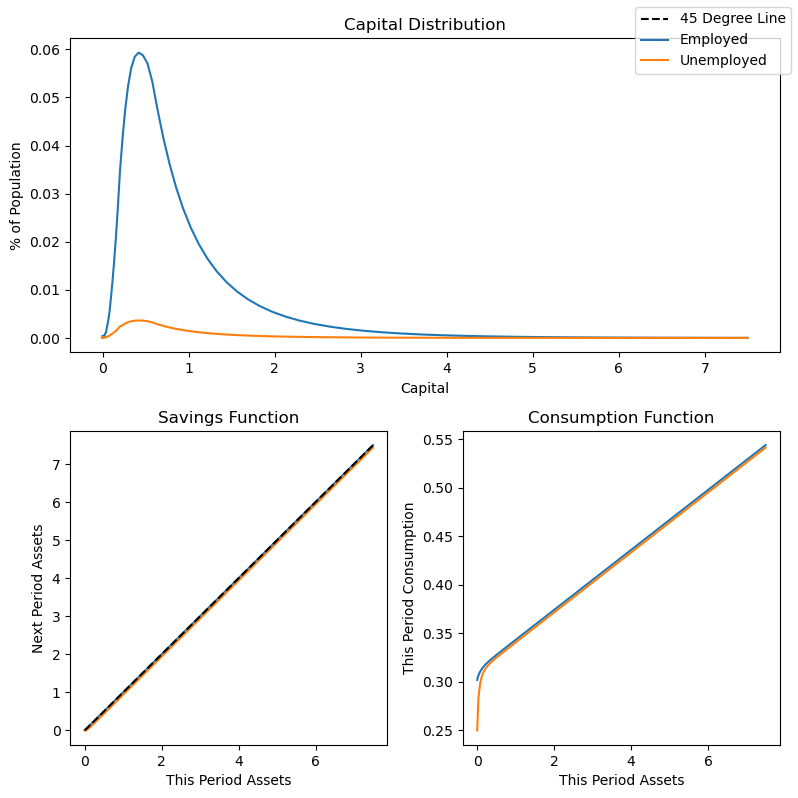

In [5]:
# intiial guess
g = get_g(10 + 0.1*jnp.tile(GRID, (2, 1)).T)  # assumed policy function is that you save this amount from each point in the grid
current_funcs = [g]  # mutatble list we reference later so we can always use the last iterations guess for g as the next one
R = 1

# egm params
policy_tol = 1e-10
policy_max_iter = 10000

# steady state finding params
capital_max_iter = 100  # max number of gueses for capital
capital_tol = 1e-16  # actual capital will be within this distance of capital

def simulate_R(R, tol=policy_tol, max_iter=policy_max_iter, a_t=GRID):
    '''
    Simulates an economy at the steady state with the given real interest rate
    '''
    # current econmic conditions
    g, = current_funcs  # policy function
    _, _, _, _, earnings, employ_trans_mat = get_economy(R)  # economic variables

    # egm
    for _ in range(max_iter):
        # update rule
        a_l, _ = euler_back(g, employ_trans_mat, R, earnings, R, earnings)
        g, last_g = get_g(a_l), g

        # exit conditions
        diff = jnp.abs(g(a_t) - last_g(a_t)).max()
        if diff < tol:
            break
    else:
        warnings.warn('Policy Loop: Max iteration count exceeded')
    
    # calculate distribution of assets
    trans_mat = income_trans_mat(g, employ_trans_mat)
    assert jnp.allclose(trans_mat.sum(axis=0).todense(), 1)  # check we have a markov matrix
    vals, vecs = jnp.linalg.eig(trans_mat.todense())  # stationary distribution is an eigenvector
    i = jnp.abs(vals).argmax()
    dist = vecs[:, i].real  # dominant eigenvector
    dist /= dist.sum()  # normalize to sum to 1
    dist = dist.reshape((-1, 2), order='F')  # reshape to keep track of labor efficiency state, first column is low, second is high

    # get aggregate demand
    B_t = (a_t * dist.T).sum()
    current_funcs[0] = g
    return B_t, g, dist, a_l

R_ss = brentq(lambda R: simulate_R(R)[0] - B, 1, 1/BETA, xtol=capital_tol, maxiter=capital_max_iter)
_, g_ss, dist_ss, a_l_ss = simulate_R(R_ss)  # get the economic variables
_, Y_ss, D_ss, tau_ss, earnings_ss, _ = get_economy(R_ss)  # economic variables
PA_ss = PB_ss = Y_ss/(1-THETA * R_ss**(-1))  # a couple more steady states
c_ss = get_c(g_ss, R_ss, earnings_ss)

# setup plot
n = 75
fig, axs = plt.subplots(2, 2)
fig.set_figwidth(8)
fig.set_figheight(8)
gs = axs[0, 0].get_gridspec()
for ax in axs[0, :]:  # remove the axis so we can have one big one
    ax.remove()
axtop = fig.add_subplot(gs[0, :])
axtop.set_title('Capital Distribution')
axtop.set_xlabel('Capital')
axtop.set_ylabel('% of Population')
axs[1, 0].set_title('Savings Function')
axs[1, 0].set_xlabel('This Period Assets')
axs[1, 0].set_ylabel('Next Period Assets')
axs[1, 1].set_title('Consumption Function')
axs[1, 1].set_xlabel('This Period Assets')
axs[1, 1].set_ylabel('This Period Consumption')

# plot it
axtop.plot(GRID[:n], dist_ss[:n, 0], label='Employed')
axtop.plot(GRID[:n], dist_ss[:n, 1], label='Unemployed')
axs[1, 0].plot(GRID[:n], g_ss(GRID)[:n])
min_max = lambda g: [g.min(), g.max()]
axs[1, 0].plot(min_max(GRID[:n]), min_max(GRID[:n]), 'k--', label='45 Degree Line')
axs[1, 1].plot(GRID[:n], get_c(g_ss, R_ss, earnings_ss)(GRID)[:n])

# final things
fig.legend()
fig.tight_layout()

#### Residual
We'll create a residual function that takes
- The policy functions, encoded as the $a_l$ that maps to the gridpoints
- The wealth distribution, encoded as the density at each of the gridpoints
- Aggregate variables ()
and returns the
- Euler equation residuals
- Distribution change residuals
- The aggregate residuals

In [6]:
def residual(X_l, X_t, X_p, err):
    ## decompose to individual vectors
    decomp = lambda X: (
            get_g(X[:2*N_A].reshape((-1, 2), order='F')),  # savings functions
            jnp.hstack((1-X[2*N_A:4*N_A-1].sum(), X[2*N_A:4*N_A-1])).reshape((-1, 2), order='F'),  # dist, sums to 1
            X[4*N_A-1],  # R
            X[4*N_A],  # M
            X[4*N_A+1],  # pi
            X[4*N_A+2],  # PA
            X[4*N_A+3],  # PB
            X[4*N_A+4],  # U
            X[4*N_A+5],  # Z
            X[4*N_A+6],  # xi
        )
    _, dist_l, _, _, pi_l, _, _, U_l, Z_l, xi_l = decomp(X_l)
    g_t, dist_t, R_t, M_t, pi_t, PA_t, PB_t, U_t, Z_t, xi_t = decomp(X_t)
    g_p, _, R_p, M_p, pi_p, PA_p, PB_p, U_p, Z_p, _ = decomp(X_p)
    err_Z, err_xi = err

    # economic variables
    W_t, Y_t, _, _, earnings_t, employ_trans_mat_t = get_economy(R_t, M_t, Z_t, U_t, U_l)
    _, _, _, _, earnings_p, _ = get_economy(R_p, M_p, Z_p, U_p, U_t)

    # euler residuals
    # idea: use the euler equation with euler_back and the consumption function to find current consumption and compare them
    c_t = get_c(g_t, R_t, earnings_t)
    a_l, c_t2 = euler_back(g_p, employ_trans_mat_t, R_t, earnings_p, R_p, earnings_p)
    euler_resid = jnp.column_stack((c_t(a_l[:, 0])[:, 0], c_t(a_l[:, 1])[:, 1])) / c_t2 - 1

    # distribution residuals
    tran_mat_t = income_trans_mat(g_t, employ_trans_mat_t)
    dist_residual = dist_t.ravel('F') - tran_mat_t @ dist_l.ravel('F')

    # aggregation
    B_t = (GRID * dist_t.T).sum()

    return jnp.hstack([
            euler_resid.ravel('F'),  # euler residuals
            dist_residual[1:],  # distribution residual, first condition is enforeced by forcing sum = 1
            B - B_t,  # bond markets clear
            M_t - (1-U_t - (1-DELTA)*(1-U_l)) / (U_l + DELTA*(1-U_l)),  # M def
            1 - THETA*pi_t**(PSI-1) - (1-THETA) * (PA_t/PB_t)**(1-PSI),  # inflation law of motion
            PA_t - PSI/(PSI-1) * Y_t * (W_t + PHI*M_t - (1-DELTA)*PHI*M_p) / Z_t - THETA * R_p**(-1) * pi_p**PSI * PA_p,  # PA def
            PB_t - Y_t - THETA * R_p**(-1) * pi_p**PSI * PB_p,  # PB def
            R_t - R_ss * pi_l**OMEGA * xi_l / pi_t,  # real interest rate def
            RHO_Z * jnp.log(Z_l) + err_Z - jnp.log(Z_t),  # productivity law of motion
            RHO_XI * jnp.log(xi_l) + err_xi - jnp.log(xi_t),  # monetary policy law of motion
        ])

# build steady state vectors
X_ss = jnp.hstack((
        a_l_ss.ravel('F'),
        dist_ss.ravel('F')[1:],
        R_ss, M_ss, pi_ss, PA_ss, PB_ss, U_ss, Z_ss, xi_ss
    ))
err_ss = jnp.zeros(2)

# check our solution
assert jnp.allclose(residual(X_ss, X_ss, X_ss, err_ss), 0, atol=1e-6)

# get matricies
AA = jax.jacfwd(lambda X_l: residual(X_l, X_ss, X_ss, err_ss))(X_ss)
BB = jax.jacfwd(lambda X_t: residual(X_ss, X_t, X_ss, err_ss))(X_ss)
CC = jax.jacfwd(lambda X_p: residual(X_ss, X_ss, X_p, err_ss))(X_ss)
EE = jax.jacfwd(lambda err: residual(X_ss, X_ss, X_ss, err))(err_ss)

#### Linear Time Iteration
We'll use Linear Time Iteration from Rendahl (2017) to solve for policy rules

In [18]:
def linear_time_iteration(A, B, C, E, max_iter=1000, tol=1e-7):
    '''
    Implentation of Linear Time Iteration from Rendahl (2017) to find
    a policy rule for a dynamic system. 

    Note: This doesn't check BK solutions, so it can output invalid
    policy rules.
    '''
    # intial guess
    P = jnp.zeros_like(A)  # intial guess is all zeros

    # run incremental update algorithms
    for _ in range(max_iter):
        # update rule
        # P = -jnp.linalg.lstsq(B + C@P, A)[0]  # handle noninvertable inputs
        P = -jnp.linalg.inv(B + C@P) @ A  # this is much faster

        # exit condition
        diff = jnp.abs(A + B@P + C@P@P).max()
        if diff < tol:
            break
    else:
        warnings.warn('Max iteration count exceeded')

    # get error matrix
    Q = -jnp.linalg.inv(B + C@P) @ E  # @E at the end keeps only releveant columns 

    return P, Q

PP, QQ = linear_time_iteration(AA, BB, CC, EE)

#### Impulse Response
Use our policy rule to simulate the response to a shock.

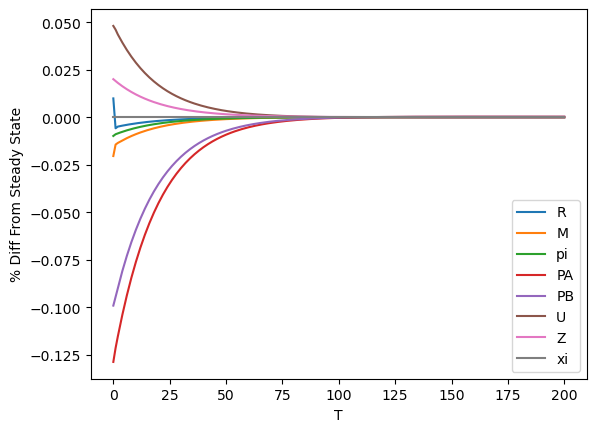

In [13]:
## output shock
# config
T = 200

# simplate it
X = (QQ @ jnp.array([SIGMA_Z, 0])).ravel()
g_path = [get_g(a_l_ss + X[:2*N_A].reshape((-1, 2), order='F'))]
dist_path = [dist_ss + jnp.hstack((-X[2*N_A:4*N_A-1].sum(), X[2*N_A:4*N_A-1])).reshape((-1, 2), order='F')]
agg_path = [X[4*N_A-1:]]
for t in range(1, T+1):
    # iterate to next period
    X = PP @ X

    # get variables
    g_path.append(get_g(a_l_ss + X[:2*N_A].reshape((-1, 2), order='F')))
    dist_path.append(dist_ss + jnp.hstack((-X[2*N_A:4*N_A-1].sum(), X[2*N_A:4*N_A-1])).reshape((-1, 2), order='F'))
    agg_path.append(X[4*N_A-1:])
agg_path = jnp.array(agg_path)

# plot it
plt.xlabel('T')
plt.ylabel('% Diff From Steady State')
plt.plot(agg_path / X_ss[4*N_A-1:], label=['R', 'M', 'pi', 'PA', 'PB', 'U', 'Z', 'xi'])
plt.legend()

In [14]:
# animation
# setup plot
fig, axs = plt.subplots(2, 2)
fig.suptitle('t=0')
fig.set_figwidth(8)
fig.set_figheight(8)
gs = axs[0, 0].get_gridspec()
for ax in axs[0, :]:  # remove the axis so we can have one big one
    ax.remove()
axtop = fig.add_subplot(gs[0, :])
axtop.set_title('Wealth Distribution')
axtop.set_xlabel('Wealth')
axtop.set_ylabel('% of Population')
axtop.set_xlim((A_MIN, A_MAX))
axtop.set_ylim((0, 1.1*max([d.max() for d in dist_path])))
axs[1, 0].set_title('Savings Function')
axs[1, 0].set_xlabel('This Period Assets')
axs[1, 0].set_ylabel('% Deviation from Steady State')
axs[1, 0].set_xlim((A_MIN, A_MAX))
axs[1, 1].set_title('Consumption Function')
axs[1, 1].set_xlabel('This Period Assets')
axs[1, 1].set_ylabel('% Deviation from Steady State')
axs[1, 1].set_xlim((A_MIN, A_MAX))

# plot it
ln_dist_low, = axtop.plot([], [], label='Employed')
ln_dist_high, = axtop.plot([], [], label='Unemployed')
ln_g_low, = axs[1, 0].plot([], [])
ln_g_high, = axs[1, 0].plot([], [])
ln_c_low, = axs[1, 1].plot([], [])
ln_c_high, = axs[1, 1].plot([], [])

# final things
fig.legend()
fig.tight_layout()

# update frame
def update(t):
    fig.suptitle(f't={t}')

    # update distribution
    dist_t = dist_path[t]
    ln_dist_low.set_data(GRID, dist_t[:, 0])
    ln_dist_high.set_data(GRID, dist_t[:, 1])

    # update savings
    g_t = g_path[t]
    savings = (g_t(GRID) - g_ss(GRID)) / g_ss(GRID)
    ln_g_low.set_data(GRID, savings[:, 0])
    ln_g_high.set_data(GRID, savings[:, 1])

    # update consumption
    R_t = R_ss * (1 + agg_path[t, 0])
    Z_t = 1 + agg_path[t, 6]
    M_t = M_ss * (1 + agg_path[t, 1])
    U_l = U_ss * (1 + agg_path[t-1, 5])  # last element is used as steady state
    U_t = U_ss * (1 + agg_path[t, 5])
    earnings_t = get_economy(R_t, M_t, Z_t, U_t, U_l)[4]
    consumption = (get_c(g_t, R_t, earnings_t)(GRID) - c_ss(GRID)) / c_ss(GRID)
    ln_c_low.set_data(GRID, consumption[:, 0])
    ln_c_high.set_data(GRID, consumption[:, 1])
    

# animate it
plt.close()  # dont show empty figure
anim = animation.FuncAnimation(fig, update, frames=T+1, interval=50, repeat=False)
HTML(anim.to_html5_video())

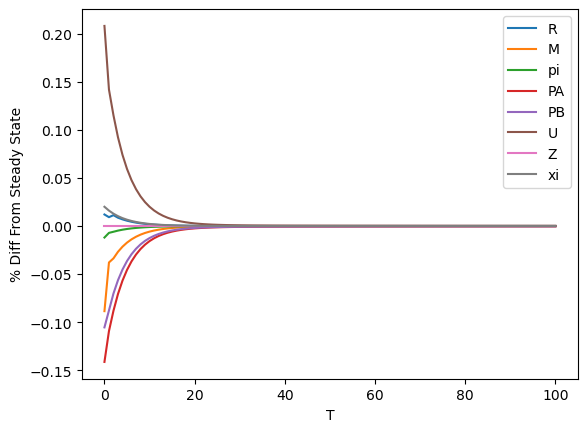

In [15]:
## monetary policy shock
# config
T = 100

# simplate it
X = (QQ @ jnp.array([0, SIGMA_XI])).ravel()
g_path = [get_g(a_l_ss + X[:2*N_A].reshape((-1, 2), order='F'))]
dist_path = [dist_ss + jnp.hstack((-X[2*N_A:4*N_A-1].sum(), X[2*N_A:4*N_A-1])).reshape((-1, 2), order='F')]
agg_path = [X[4*N_A-1:]]
for t in range(1, T+1):
    # iterate to next period
    X = PP @ X

    # get variables
    g_path.append(get_g(a_l_ss + X[:2*N_A].reshape((-1, 2), order='F')))
    dist_path.append(dist_ss + jnp.hstack((-X[2*N_A:4*N_A-1].sum(), X[2*N_A:4*N_A-1])).reshape((-1, 2), order='F'))
    agg_path.append(X[4*N_A-1:])
agg_path = jnp.array(agg_path)

# plot it
plt.xlabel('T')
plt.ylabel('% Diff From Steady State')
plt.plot(agg_path / X_ss[4*N_A-1:], label=['R', 'M', 'pi', 'PA', 'PB', 'U', 'Z', 'xi'])
plt.legend()

In [16]:
# animation
# setup plot
fig, axs = plt.subplots(2, 2)
fig.suptitle('t=0')
fig.set_figwidth(8)
fig.set_figheight(8)
gs = axs[0, 0].get_gridspec()
for ax in axs[0, :]:  # remove the axis so we can have one big one
    ax.remove()
axtop = fig.add_subplot(gs[0, :])
axtop.set_title('Wealth Distribution')
axtop.set_xlabel('Wealth')
axtop.set_ylabel('% of Population')
axtop.set_xlim((A_MIN, A_MAX))
axtop.set_ylim((0, 1.1*max([d.max() for d in dist_path])))
axs[1, 0].set_title('Savings Function')
axs[1, 0].set_xlabel('This Period Assets')
axs[1, 0].set_ylabel('% Deviation from Steady State')
axs[1, 0].set_xlim((A_MIN, A_MAX))
axs[1, 1].set_title('Consumption Function')
axs[1, 1].set_xlabel('This Period Assets')
axs[1, 1].set_ylabel('% Deviation from Steady State')
axs[1, 1].set_xlim((A_MIN, A_MAX))
# axs[1, 1].set_ylim((-0.005, 0.02))

# plot it
ln_dist_low, = axtop.plot([], [], label='Employed')
ln_dist_high, = axtop.plot([], [], label='Unemployed')
ln_g_low, = axs[1, 0].plot([], [])
ln_g_high, = axs[1, 0].plot([], [])
ln_c_low, = axs[1, 1].plot([], [])
ln_c_high, = axs[1, 1].plot([], [])

# final things
fig.legend()
fig.tight_layout()

# update frame
def update(t):
    fig.suptitle(f't={t}')

    # update distribution
    dist_t = dist_path[t]
    ln_dist_low.set_data(GRID, dist_t[:, 0])
    ln_dist_high.set_data(GRID, dist_t[:, 1])

    # update savings
    g_t = g_path[t]
    savings = (g_t(GRID) - g_ss(GRID)) / g_ss(GRID)
    ln_g_low.set_data(GRID, savings[:, 0])
    ln_g_high.set_data(GRID, savings[:, 1])

    # update consumption
    R_t = R_ss * (1 + agg_path[t, 0])
    Z_t = 1 + agg_path[t, 6]
    M_t = M_ss * (1 + agg_path[t, 1])
    U_l = U_ss * (1 + agg_path[t-1, 5])  # last element is used as steady state
    U_t = U_ss * (1 + agg_path[t, 5])
    earnings_t = get_economy(R_t, M_t, Z_t, U_t, U_l)[4]
    consumption = (get_c(g_t, R_t, earnings_t)(GRID) - c_ss(GRID)) / c_ss(GRID)
    ln_c_low.set_data(GRID, consumption[:, 0])
    ln_c_high.set_data(GRID, consumption[:, 1])


# animate it
plt.close()  # dont show empty figure
anim = animation.FuncAnimation(fig, update, frames=T+1, interval=50, repeat=False)
HTML(anim.to_html5_video())